In [ ]:
#@title uploader
file_id = "1K-ClB-MKo6VE1_K01DcoUhFaG0qjeaMX" #@param {type:"string"}
!pip install -U -q PyDrive

from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials

# 1. Authenticate and create the PyDrive client.
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

# PyDrive reference:
# https://googledrive.github.io/PyDrive/docs/build/html/index.html


from google.colab import auth
auth.authenticate_user()

from googleapiclient.discovery import build
drive_service = build('drive', 'v3')

# Replace the assignment below with your file ID
# to download a different file.
#
# A file ID looks like: 1gLBqEWEBQDYbKCDigHnUXNTkzl-OslSO

import io
from googleapiclient.http import MediaIoBaseDownload

request = drive_service.files().get_media(fileId=file_id)
downloaded = io.BytesIO()
downloader = MediaIoBaseDownload(downloaded, request)
done = False
while done is False:
  # _ is a placeholder for a progress object that we ignore.
  # (Our file is small, so we skip reporting progress.)
  _, done = downloader.next_chunk()

fileId = drive.CreateFile({'id': file_id }) #DRIVE_FILE_ID is file id example: 1iytA1n2z4go3uVCwE_vIKouTKyIDjEq
print(fileId['title'])  
fileId.GetContentFile(fileId['title'])  # Save Drive file as a local file

!unzip {fileId['title']}

Streaming output truncated to the last 5000 lines.
  inflating: Face Mask Dataset/Train/WithoutMask/1855.png  
  inflating: Face Mask Dataset/Train/WithoutMask/1856.png  
  inflating: Face Mask Dataset/Train/WithoutMask/1857.png  
  inflating: Face Mask Dataset/Train/WithoutMask/1858.png  
  inflating: Face Mask Dataset/Train/WithoutMask/1859.png  
  inflating: Face Mask Dataset/Train/WithoutMask/1860.png  
  inflating: Face Mask Dataset/Train/WithoutMask/1861.png  
  inflating: Face Mask Dataset/Train/WithoutMask/1862.png  
  inflating: Face Mask Dataset/Train/WithoutMask/1863.png  
  inflating: Face Mask Dataset/Train/WithoutMask/1864.png  
  inflating: Face Mask Dataset/Train/WithoutMask/1865.png  
  inflating: Face Mask Dataset/Train/WithoutMask/1866.png  
  inflating: Face Mask Dataset/Train/WithoutMask/1867.png  
  inflating: Face Mask Dataset/Train/WithoutMask/1868.png  
  inflating: Face Mask Dataset/Train/WithoutMask/1869.png  
  inflating: Face Mask Dataset/Train/WithoutMask/

In [ ]:
%tensorflow_version 2.x
import tensorflow as tf
device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))

Found GPU at: /device:GPU:0


In [ ]:
from tensorflow.keras import layers
import numpy as np
import matplotlib.pyplot as plt
import cv2

Load data

In [ ]:
image_size = (128,128)
base_dir = '/content/Face Mask Dataset/'
train_gen = tf.keras.preprocessing.image.ImageDataGenerator(horizontal_flip=True, rescale=1./255)
val_gen = tf.keras.preprocessing.image.ImageDataGenerator(rescale=1./255.)
test_gen = tf.keras.preprocessing.image.ImageDataGenerator(rescale=1./255.)    

train_ds = train_gen.flow_from_directory(base_dir+'Train',target_size=image_size,seed=42, shuffle=True)
val_ds = val_gen.flow_from_directory(base_dir+'Validation',target_size=image_size,seed=42)
test_ds = test_gen.flow_from_directory(base_dir+'Test',target_size=image_size,seed=42)        

Found 10000 images belonging to 2 classes.
Found 800 images belonging to 2 classes.
Found 992 images belonging to 2 classes.


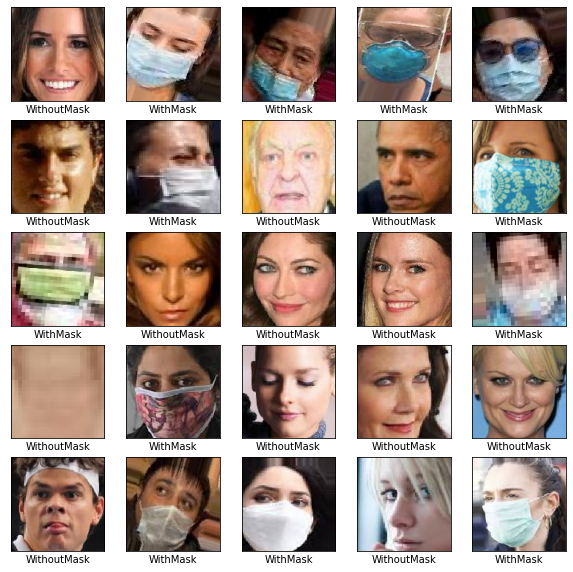

In [ ]:
class_names = {v:k for k,v in train_ds.class_indices.items()}
images, labels  = next(iter(train_ds))
plt.figure(figsize=(10,10))
for i in range(25):
    plt.subplot(5,5,i+1)
    plt.imshow(images[i])
    plt.xticks([])
    plt.yticks([])
    plt.xlabel(class_names[labels[i][1]])

plt.show()

In [ ]:
vgg= tf.keras.applications.VGG19(include_top = False, input_shape = (128,128,3))
vgg.trainable = False

model = tf.keras.Sequential([
    vgg,
    layers.Flatten(),
    layers.Dense(2,activation='sigmoid')
])

model.compile(
    optimizer=tf.keras.optimizers.Adam(),
    loss=tf.keras.losses.BinaryCrossentropy(),
    metrics=[tf.keras.metrics.BinaryAccuracy()]
)
model.summary()

80142336/80134624 [==============================] - 0s 0us/step
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg19 (Functional)           (None, 4, 4, 512)         20024384  
_________________________________________________________________
flatten (Flatten)            (None, 8192)              0         
_________________________________________________________________
dense (Dense)                (None, 2)                 16386     
Total params: 20,040,770
Trainable params: 16,386
Non-trainable params: 20,024,384
_________________________________________________________________


In [ ]:
# Using EarlyStopping, end training when val_accuracy is not improved for 4 consecutive times
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_binary_accuracy',mode='max',
                                patience=4,restore_best_weights=True)

# Using ReduceLROnPlateau, the learning rate is reduced by half when val_accuracy is not improved for 2 consecutive times
lr_scheduler = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_binary_accuracy',factor=0.5,
                                patience=2,verbose=1)

# training
history = model.fit(train_ds,batch_size=32,epochs=30,
        validation_data=val_ds,callbacks=[early_stopping,lr_scheduler])

Epoch 1/30
313/313 [==============================] - 54s 70ms/step - loss: 0.0910 - binary_accuracy: 0.9701 - val_loss: 0.0354 - val_binary_accuracy: 0.9931
Epoch 2/30
313/313 [==============================] - 20s 64ms/step - loss: 0.0342 - binary_accuracy: 0.9898 - val_loss: 0.0213 - val_binary_accuracy: 0.9956
Epoch 3/30
313/313 [==============================] - 20s 63ms/step - loss: 0.0258 - binary_accuracy: 0.9924 - val_loss: 0.0138 - val_binary_accuracy: 1.0000
Epoch 4/30
313/313 [==============================] - 20s 65ms/step - loss: 0.0202 - binary_accuracy: 0.9937 - val_loss: 0.0190 - val_binary_accuracy: 0.9987
Epoch 5/30
313/313 [==============================] - 20s 64ms/step - loss: 0.0156 - binary_accuracy: 0.9961 - val_loss: 0.0089 - val_binary_accuracy: 0.9987

Epoch 00005: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.
Epoch 6/30
313/313 [==============================] - 20s 62ms/step - loss: 0.0119 - binary_accuracy: 0.9973 - val_loss: 0.0089 -

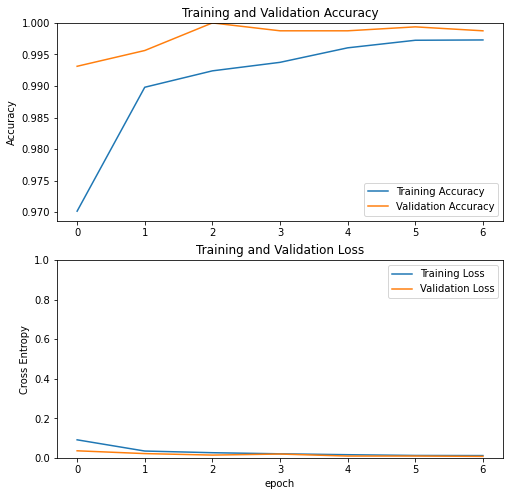

In [ ]:
acc = history.history['binary_accuracy']
val_acc = history.history['val_binary_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.ylim([0,1.0])
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

In [ ]:
# test model
model.evaluate(test_ds)

31/31 [==============================] - 2s 59ms/step - loss: 0.0241 - binary_accuracy: 0.9919


[0.02406371384859085, 0.9919354915618896]

In [ ]:
# save model
model.save('VGG19-Face Mask Detection.h5')

In [ ]:
!wget --no-check-certificate \
    https://raw.githubusercontent.com/computationalcore/introduction-to-opencv/master/assets/haarcascade_frontalface_default.xml \
    -O haarcascade_frontalface_default.xml

--2021-07-20 17:51:27--  https://raw.githubusercontent.com/computationalcore/introduction-to-opencv/master/assets/haarcascade_frontalface_default.xml
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 930127 (908K) [text/plain]
Saving to: ‘haarcascade_frontalface_default.xml’

haarcascade_frontal 100%[===================>] 908.33K  --.-KB/s    in 0.02s   

2021-07-20 17:51:27 (57.6 MB/s) - ‘haarcascade_frontalface_default.xml’ saved [930127/930127]



In [ ]:
face_model = cv2.CascadeClassifier("/content/haarcascade_frontalface_default.xml")

In [ ]:
mask_label = {0:'MASK',1:'NO MASK'}
dist_label = {0:(0,255,0),1:(255,0,0)} # rectangle color

In [ ]:
def plot_image(image,subplot):
    plt.subplot(*subplot)
    plt.imshow(image)
    plt.xticks([])
    plt.yticks([])
    plt.show

def predict_image(image_dir):
    img = cv2.imread(image_dir)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    
    #returns a list of (x,y,w,h) tuples
    faces = face_model.detectMultiScale(img,scaleFactor=1.1, minNeighbors=4)
    
    out_img = cv2.cvtColor(img, cv2.COLOR_RGB2BGR)

    plt.figure(figsize=(20,20))
    plot_image(out_img,(1,2,1))
    
    for i in range(len(faces)):
        (x,y,w,h) = faces[i]
        crop = out_img[y:y+h,x:x+w]
        crop = cv2.resize(crop,(128,128))
        crop = np.reshape(crop,[1,128,128,3])/255.0
        mask_result = model.predict(crop).argmax()
        cv2.rectangle(out_img,(x,y),(x+w,y+h),dist_label[mask_result],1)
    
    plot_image(out_img,(1,2,2))